# 가스 터빈 추진 플랜트 제조 공정의 부식 예측

## 데이터 소개 및 분석 프로세스 수립

### 데이터 수집  
데이터 소스: https://www.kaggle.com/datasets/elikplim/maintenance-of-naval-propulsion-plants-data-set/download?datasetVersionNumber=1/

- 제조 공정 계측값
- 컴프레셔/터빈 부식 정도

### 데이터 전처리
- 결측값 여부  
- Target Feature 생성
- 범주형 Feature 탐색
- 상관성 분석

### 모델 생성  
- PCA를 활용한 Feature Selection
- 다양한 Regressor 모델 생성
- Hypertuning

### 모델 평가 및 의사결정
- Feature Importance

matplotlib 한글 깨짐 현상 해결
> 셀 실행 후 런타임 재시작 필요

In [1]:
# matplotlib 한글깨짐 현상 해결
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [2]:
# 필요한 파이썬 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

from sklearn import metrics

from sklearn.metrics import explained_variance_score, mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [3]:
naval_df = pd.read_csv("/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/10_maintenance_of_naval_propulsion_plants/navalplantmaintenance.csv",
                       delim_whitespace= True, header=None)
naval_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


In [4]:
naval_df.shape

(11934, 18)

## 1. 데이터 탐색

### 1) 컬럼명 생성

In [5]:
naval_df.columns = ["lever_position", "ship_speed", "gt_shaft", "gt_rate", "gg_rate", "sp_torque", "pp_torque", "hpt_temp", "gt_c_i_temp", "gt_c_o_temp", "hpt_pressure", "gt_c_i_pressure", "gt_c_o_pressure", "gt_exhaust_pressure", "turbine_inj_control", "fuel_flow", "gt_c_decay", "gt_t_decay"]

In [6]:
naval_df.head()

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_i_temp,gt_c_o_temp,hpt_pressure,gt_c_i_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


### 2) 결측값

In [7]:
# 결측값 없음
naval_df.isna().sum()

lever_position         0
ship_speed             0
gt_shaft               0
gt_rate                0
gg_rate                0
sp_torque              0
pp_torque              0
hpt_temp               0
gt_c_i_temp            0
gt_c_o_temp            0
hpt_pressure           0
gt_c_i_pressure        0
gt_c_o_pressure        0
gt_exhaust_pressure    0
turbine_inj_control    0
fuel_flow              0
gt_c_decay             0
gt_t_decay             0
dtype: int64

In [8]:
naval_df = naval_df.dropna()

In [9]:
naval_df.head()

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_i_temp,gt_c_o_temp,hpt_pressure,gt_c_i_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


### 3) 데이터 통계값

In [10]:
naval_df.describe()

,lever_position,ship_speed,gt_shaft,gt_rate,gg_rate,sp_torque,pp_torque,hpt_temp,gt_c_i_temp,gt_c_o_temp,hpt_pressure,gt_c_i_pressure,gt_c_o_pressure,gt_exhaust_pressure,turbine_inj_control,fuel_flow,gt_c_decay,gt_t_decay
count,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.0,11934.000000,11934.000000,1.193400e+04,11934.000000,11934.000000,11934.000000,11934.000000,11934.00000,11934.0000
mean,5.166667,15.000000,27247.498685,2136.289256,8200.947312,227.335768,227.335768,735.495446,288.0,646.215331,2.352963,9.980000e-01,12.297123,1.029474,33.641261,0.662440,0.97500,0.9875
std,2.626388,7.746291,22148.613155,774.083881,1091.315507,200.495889,200.495889,173.680552,0.0,72.675882,1.084770,2.220539e-16,5.337448,0.010390,25.841363,0.507132,0.01472,0.0075
min,1.138000,3.000000,253.547000,1307.675000,6589.002000,5.304000,5.304000,442.364000,288.0,540.442000,1.093000,9.980000e-01,5.828000,1.019000,0.000000,0.068000,0.95000,0.9750
25%,3.144000,9.000000,8375.883750,1386.758000,7058.324000,60.317000,60.317000,589.872750,288.0,578.092250,1.389000,9.980000e-01,7.447250,1.020000,13.677500,0.246000,0.96200,0.9810
50%,5.140000,15.000000,21630.659000,1924.326000,8482.081500,175.268000,175.268000,706.038000,288.0,637.141500,2.083000,9.980000e-01,11.092000,1.026000,25.276500,0.496000,0.97500,0.9875
75%,7.148000,21.000000,39001.426750,2678.079000,9132.606000,332.364750,332.364750,834.066250,288.0,693.924500,2.981000,9.980000e-01,15.658000,1.036000,44.552500,0.882000,0.98800,0.9940
max,9.300000,27.000000,72784.872000,3560.741000,9797.103000,645.249000,645.249000,1115.797000,288.0,789.094000,4.560000,9.980000e-01,23.140000,1.052000,92.556000,1.832000,1.00000,1.0000


## 2. Feature 변환

### 1) Feature 탐색

#### 총 Feature 개수 확인

In [11]:
naval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   lever_position       11934 non-null  float64
 1   ship_speed           11934 non-null  float64
 2   gt_shaft             11934 non-null  float64
 3   gt_rate              11934 non-null  float64
 4   gg_rate              11934 non-null  float64
 5   sp_torque            11934 non-null  float64
 6   pp_torque            11934 non-null  float64
 7   hpt_temp             11934 non-null  float64
 8   gt_c_i_temp          11934 non-null  float64
 9   gt_c_o_temp          11934 non-null  float64
 10  hpt_pressure         11934 non-null  float64
 11  gt_c_i_pressure      11934 non-null  float64
 12  gt_c_o_pressure      11934 non-null  float64
 13  gt_exhaust_pressure  11934 non-null  float64
 14  turbine_inj_control  11934 non-null  float64
 15  fuel_flow            11934 non-null 

#### Feature 별 유일한 값 개수 확인

In [14]:
[(f"{col} :", len(naval_df[col].unique())) for col in naval_df]

[('lever_position :', 9),
 ('ship_speed :', 9),
 ('gt_shaft :', 11430),
 ('gt_rate :', 3888),
 ('gg_rate :', 11834),
 ('sp_torque :', 4286),
 ('pp_torque :', 4286),
 ('hpt_temp :', 11772),
 ('gt_c_i_temp :', 1),
 ('gt_c_o_temp :', 11506),
 ('hpt_pressure :', 524),
 ('gt_c_i_pressure :', 1),
 ('gt_c_o_pressure :', 4209),
 ('gt_exhaust_pressure :', 19),
 ('turbine_inj_control :', 8496),
 ('fuel_flow :', 696),
 ('gt_c_decay :', 51),
 ('gt_t_decay :', 26)]

In [12]:
print(naval_df.nunique().sort_values())

gt_c_i_temp                1
gt_c_i_pressure            1
lever_position             9
ship_speed                 9
gt_exhaust_pressure       19
gt_t_decay                26
gt_c_decay                51
hpt_pressure             524
fuel_flow                696
gt_rate                 3888
gt_c_o_pressure         4209
sp_torque               4286
pp_torque               4286
turbine_inj_control     8496
gt_shaft               11430
gt_c_o_temp            11506
hpt_temp               11772
gg_rate                11834
dtype: int64


#### Feature 제거

In [15]:
naval_df = naval_df.drop(['gt_c_i_pressure', 'gt_c_i_temp'], axis=1)

### 3. Target Feature 정의

#### 1) 데이터 확인

In [16]:
naval_df.gt_c_decay.unique()

array([0.95 , 0.951, 0.952, 0.953, 0.954, 0.955, 0.956, 0.957, 0.958,
       0.959, 0.96 , 0.961, 0.962, 0.963, 0.964, 0.965, 0.966, 0.967,
       0.968, 0.969, 0.97 , 0.971, 0.972, 0.973, 0.974, 0.975, 0.976,
       0.977, 0.978, 0.979, 0.98 , 0.981, 0.982, 0.983, 0.984, 0.985,
       0.986, 0.987, 0.988, 0.989, 0.99 , 0.991, 0.992, 0.993, 0.994,
       0.995, 0.996, 0.997, 0.998, 0.999, 1.   ])

In [18]:
naval_df.gt_t_decay.unique()

array([0.975, 0.976, 0.977, 0.978, 0.979, 0.98 , 0.981, 0.982, 0.983,
       0.984, 0.985, 0.986, 0.987, 0.988, 0.989, 0.99 , 0.991, 0.992,
       0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.   ])

#### 2) 그래프

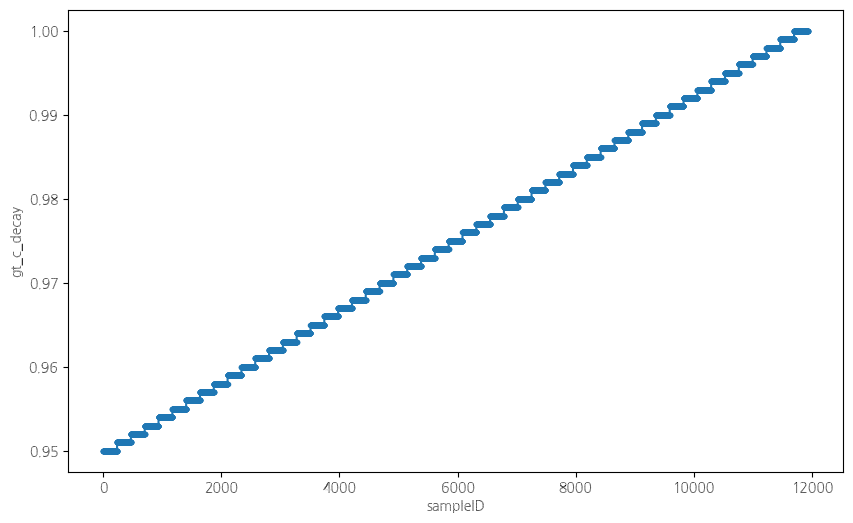

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(naval_df.index, naval_df.gt_c_decay, '.-')
plt.xlabel("sampleID")
plt.ylabel("gt_c_decay")
plt.show()

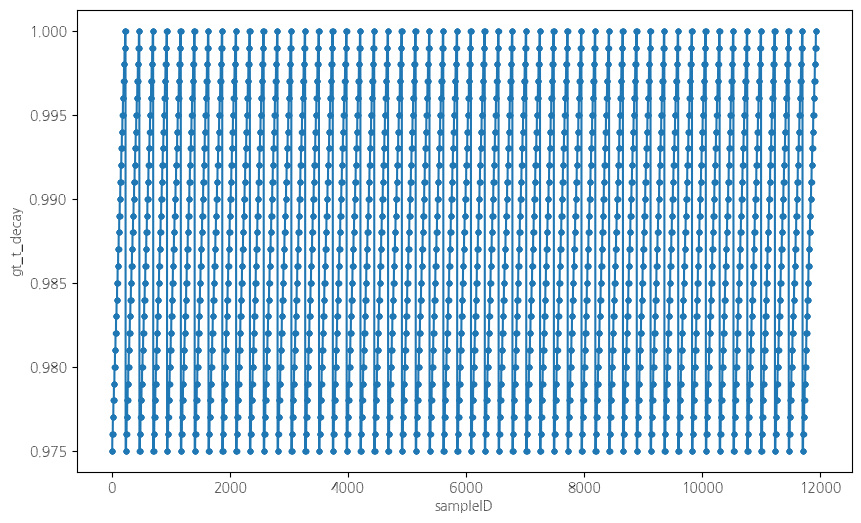

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(naval_df.index, naval_df.gt_t_decay, '.-')
plt.xlabel("sampleID")
plt.ylabel("gt_t_decay")
plt.show()